# Part II: The Power of Federated Learning for Network Security

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leolavaur/icdcs_2025/blob/main/notebooks/part2.ipynb)

In this second part, we will look at FL as a solution to the problem of sharing network data to train IDSs. We will use NSL-KDD, a commonly used (and sometimes criticized) dataset for training IDSs, and a simple neural network architecture to train our model. The IDS use case involves NIID data, so we will also see how FL can be used to *share knowledge* between different institutions.

## Section 0: Prerequisites

### Dependencies

> Be advised that Google collab currently does not support the latest versions of Python (limited to 3.11.13).
> The present notebook has been designed to work with Python 3.11, and may not work with earlier or later versions.
> Please ensure that you have the correct Python version.

If you are running this notebook in Google Colab, you can install the required dependencies by running the following cell. Otherwise, you can install them in your local environment using `uv` or `pip`.


In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/leolavaur/icdcs_2025
    %pip install -r icdcs_2025/requirements.txt
    !cp -r icdcs_2025/notebooks/utils/ .

Once you have a working environment, check that everything works, notably your GPU for the TensorFlow backend.
You can do so by running the following cell:

In [2]:
import tensorflow as tf
from IPython.utils import io

with io.capture_output(stdout=False) as _:
    print("TensorFlow version:", tf.__version__)
    print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2025-07-19 19:42:38.345843: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 19:42:38.360593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752946958.376541  100372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752946958.381265  100372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752946958.393430  100372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
Num GPUs Available: 0


2025-07-19 19:42:41.000673: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


To allow others to reproduce your results with some degree of certitude, set a seed for all the pseudo-random number generators (PRNG) that you use.
You should also run your threads deterministically, in case your ML backend optimize training.
This will have a negative impact on the performance.
On TensorFlow: 

In [3]:
import keras

keras.utils.set_random_seed(1138)

### Section 1: Data exploration 

In this section, we will explore the NSL-KDD dataset and partition it into train and test sets. We will also create a function to generate IID and NIID data partitions.

NSL-KDD is a set of network flows that have been labeled as either "normal" or one of the 22 attack clasees. The dataset is actually a modified version of the original KDD Cup 1999 dataset, which has been criticized for containing duplicate records and for not being representative of modern network traffic. NSL-KDD is a newer version of the dataset that addresses these issues. It is commonly used for training IDSs, but is still made of outdated data. For FL experiment however, it is interesting because of the amount of resources on this dataset in the literature.

In [4]:
from utils.nslkdd import load_nslkdd

dds = load_nslkdd()
dds

Dataset zip already exists.
Dataset already extracted.


DatasetDict({
    train: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'binary_label'],
        num_rows: 125973
    })
    test: Dataset({
        features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num

In [5]:
import pandas as pd

print(
    "Number of features:",
    len([feat for feat in dds["train"].features if "label" not in feat]),
)
print("Length of training set:", len(dds["train"]))
print("Length of test set:", len(dds["test"]))
print(
    f"Label distribution in training set: {pd.Series(dds['train']['label']).value_counts()}"
)

Number of features: 41
Length of training set: 125973
Length of test set: 22544
Label distribution in training set: 16    67343
14    41214
25     3633
7      3599
20     2931
27     2646
15     1493
1       956
32      892
34      890
19      201
4        53
2        30
35       20
8        18
6        11
23       10
9         9
3         8
12        7
18        4
17        3
30        2
Name: count, dtype: int64


To encode categorical features or labels, Hugging Face Datasets provides a `ClassLabel` feature type that replaces the string labels with integer indices.

In [6]:
ATTACK_LABELS = dds["train"].features["label"].names
print("Attack labels:", ATTACK_LABELS)
FEATURES = [feat for feat in dds["train"].features if "label" not in feat]
print("Features:", FEATURES)

Attack labels: ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'sqlattack', 'teardrop', 'udpstorm', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop', 'xterm']
Features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate

In [7]:
count = (
    pd.Series(dds["train"]["binary_label"])
    .value_counts()
    .set_axis(["Benign", "Malicious"])
)
print(count)
print("% of malicious samples in training set:", count["Malicious"] / count.sum() * 100)

Benign       67343
Malicious    58630
Name: count, dtype: int64
% of malicious samples in training set: 46.54171925730117


Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

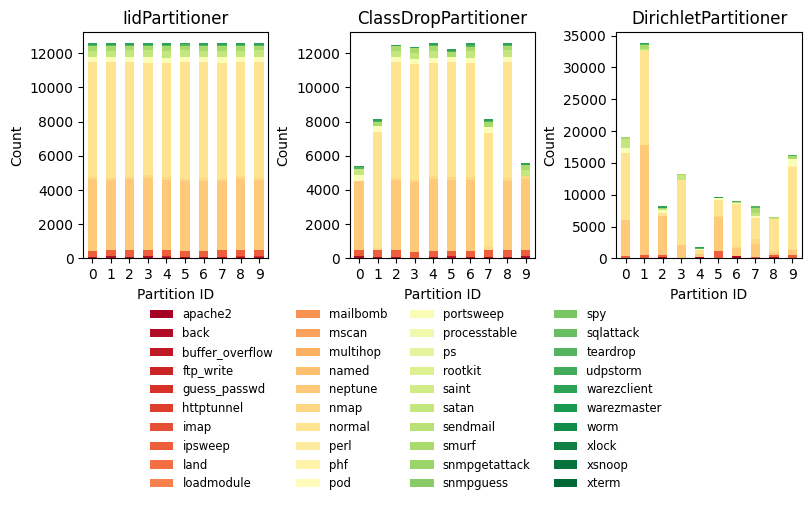

In [8]:
import matplotlib.pyplot as plt
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions

from utils.partition import ClassDropPartitioner

NUM_CLIENTS = 10

fig = plt.figure(figsize=(8, 3), constrained_layout=True)
axs = fig.subplots(1, 3)

iid_splitter = IidPartitioner(num_partitions=NUM_CLIENTS)
iid_splitter.dataset = dds["train"]
_ = plot_label_distributions(
    iid_splitter, label_name="label", axis=axs[0], title="IidPartitioner"
)

dirichlet_splitter = DirichletPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", alpha=0.8
)
dirichlet_splitter.dataset = dds["train"]
_ = plot_label_distributions(
    dirichlet_splitter, label_name="label", axis=axs[2], title="DirichletPartitioner"
)

drop_splitter = ClassDropPartitioner(
    num_partitions=NUM_CLIENTS, partition_by="label", n_drop=4
)
drop_splitter.dataset = dds["train"]
_ = plot_label_distributions(
    drop_splitter, label_name="label", axis=axs[1], title="ClassDropPartitioner"
)

# Move the legend below the plot, make it more compact and readable
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,  # Increase columns for compactness
    bbox_to_anchor=(0.5, -0.65),
    fontsize="small",
    frameon=False,
)


## Section 2: Training on centralized data

In [9]:
BATCH_SIZE = 256
NUM_EPOCHS = 5

Let us prepare the data for training, namely by creating the TensorFlow dataset objects for the training and test sets, as seen in part I. 

In [30]:
from datasets import Dataset
import tensorflow as tf


@tf.autograph.experimental.do_not_convert
def dict_to_tensor(features, label):
    """Convert a dictionary of features to a tensor."""
    # Stack all features as float32
    x = tf.stack([tf.cast(features[col], tf.float32) for col in features], axis=-1)
    return x, label


def dataset_to_tf(dataset: Dataset, batch_size: int, shuffle: bool) -> tf.data.Dataset:
    """Convert a Dataset to a tf.data.Dataset."""
    return dataset.to_tf_dataset(
        columns=[col for col in dataset.features if "label" not in col],
        label_cols="binary_label",
        shuffle=shuffle,
        batch_size=batch_size,
    ).map(dict_to_tensor)


Here we use a DNN architecture with 2 hidden layers of 64 neurons each. We use the Adam optimizer with an adaptive learning rate, and the binary cross-entropy loss function. The "dropout" layers are used to prevent overfitting by randomly dropping some neurons during training.

This is a typical architecture for this use case that you can use for netflow classification tasks.

In [11]:
import keras
from keras.optimizers import Adam

n_features = len([feat for feat in dds["train"].features if "label" not in feat])
print(n_features)

# Compute mean and std for numerical features
train_numpy = dds["train"].to_pandas()
means = train_numpy[FEATURES].mean().values
stds = train_numpy[FEATURES].std().values


def mk_model() -> keras.Model:
    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(n_features,)),
            keras.layers.Normalization(mean=means, variance=stds**2),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model


mk_model().summary()

41


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

This new model is barely more complex than the previous one, but it is a good starting point for our FL experiments.
We will also need new evaluation functions that deal with binary classification tasks while also providing per attack class metrics.

In [12]:
from typing import cast
from datasets import Dataset
import flwr
import numpy as np
from sklearn.metrics import confusion_matrix

NUM_ROUNDS = 10


def get_evaluate_fn(testset: Dataset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    history: list[dict[str, float]] = []

    test_tf = dataset_to_tf(testset, batch_size=BATCH_SIZE, shuffle=False)

    # The `evaluate` function will be called after every round by the strategy
    def evaluate_fn(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model
            np.save("fl_weights", np.array(parameters, dtype=object))

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(test_tf, verbose=cast(str, 0))

        inferences = model.predict(test_tf, verbose=cast(str, 0))
        y_pred = np.round(inferences)
        y_true = np.array(testset["binary_label"])

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        metrics = {
            "accuracy": (tn + tp) / (tn + fp + fn + tp),
            "precision": tp / (tp + fp),
            "recall": tp / (tp + fn),
            "f1": 2 * tp / (2 * tp + fp + fn),
            "miss_rate": fn / (fn + tp),
        }

        history.append(metrics | {"round": server_round, "loss": loss})

        return (loss, metrics)

    return evaluate_fn, history


def eval_model(parameters, testset: Dataset):
    """Evaluate the model with the given parameters on the test dataset."""
    fn, _ = get_evaluate_fn(testset)
    loss, metrics = fn(0, parameters, {})
    return {"loss": loss} | metrics


def eval_classes(parameters, testset):
    """Evaluate the model with the given parameters on the test dataset, per class."""
    model = mk_model()
    model.set_weights(parameters)

    class_array = np.array(testset["label"])
    test_tf = dataset_to_tf(testset, batch_size=BATCH_SIZE, shuffle=False)

    inferences = model.predict(test_tf, verbose=cast(str, 0))
    y_pred = np.round(inferences).reshape(-1)
    y_true = np.array(testset["binary_label"])

    classes_stats = {}
    for cls in set(class_array):
        class_filter = class_array == cls
        count = sum(class_filter)
        if not (count > 0):
            continue
        correct = sum(class_filter & (y_true == y_pred))
        missed = sum(class_filter & (y_true != y_pred))

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }
    ret = pd.DataFrame(classes_stats).T
    ret.index = [testset.features["label"].int2str(i) for i in ret.index]
    return ret


Let's test!

In [13]:
train_tf = dataset_to_tf(dds["train"], batch_size=BATCH_SIZE, shuffle=True)

model = mk_model()

model.fit(train_tf, epochs=NUM_EPOCHS, verbose=1)


Epoch 1/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9042 - loss: 0.2491
Epoch 2/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9694 - loss: 0.0838
Epoch 3/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9774 - loss: 0.0618
Epoch 4/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9839 - loss: 0.0484
Epoch 5/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9871 - loss: 0.0428


In [14]:
scores_centralized = eval_model(model.get_weights(), dds["test"])
scores_centralized

{'loss': 1.2970764636993408,
 'accuracy': np.float64(0.7813165365507452),
 'precision': np.float64(0.9741989679587183),
 'recall': np.float64(0.6325878594249201),
 'f1': np.float64(0.7670792780874989),
 'miss_rate': np.float64(0.36741214057507987)}

In [15]:
per_class_centralized = eval_classes(model.get_weights(), dds["test"])
per_class_centralized

,count,correct,missed,rate
apache2,737.0,109.0,628.0,0.147897
back,359.0,321.0,38.0,0.894150
buffer_overflow,20.0,11.0,9.0,0.550000
ftp_write,3.0,0.0,3.0,0.000000
guess_passwd,1231.0,17.0,1214.0,0.013810
httptunnel,133.0,87.0,46.0,0.654135
imap,1.0,1.0,0.0,1.000000
ipsweep,141.0,138.0,3.0,0.978723
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,0.0,2.0,0.000000


## Section 3: Training on local data

First, lets create one client with one partition of the data to simulate what one single organization might have access to. We start with IID distribution.

In [16]:
from flwr_datasets.partitioner import IidPartitioner

partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
partitioner.dataset = dds["train"]

shard = partitioner.load_partition(0)
shard

Dataset({
    features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'binary_label'],
    num_rows: 12598
})

In [17]:
model = mk_model()
shard_tf = dataset_to_tf(shard, batch_size=BATCH_SIZE, shuffle=True)
model.fit(shard_tf, epochs=NUM_EPOCHS, verbose=1)

score_iid = eval_model(model.get_weights(), dds["test"])
score_iid

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6744 - loss: 0.6119
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9249 - loss: 0.2418
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9431 - loss: 0.1744
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9533 - loss: 0.1469
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9539 - loss: 0.1423


{'loss': 0.8242337107658386,
 'accuracy': np.float64(0.7541696238466998),
 'precision': np.float64(0.9294380963599953),
 'recall': np.float64(0.6148211641860828),
 'f1': np.float64(0.7400806678547979),
 'miss_rate': np.float64(0.38517883581391726)}

You will notice that performance is not much lower than the centralized model. While we do have less samples, all classes are represented in this new training set. 

Now, let's train the same model architecture on a more realistic use case, where a local organization might not have access to all data. To ensure heterogeneity, we will specify droppable classes based on their ability to be detected by the model. This will allow us to simulate a more realistic scenario where some classes are more difficult to detect than others.

In [18]:
good_classes = per_class_centralized[
    (per_class_centralized["count"] > 100)  # anough samples to be relevant
    & (per_class_centralized["rate"] > 0.6)  # only classes with high enough accuracy
    & (per_class_centralized.index != "normal")  # all clients have "normal" traffic
]
good_classes.index

Index(['back', 'httptunnel', 'ipsweep', 'neptune', 'portsweep', 'saint',
       'satan', 'smurf'],
      dtype='object')

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12597 [00:00<?, ? examples/s]

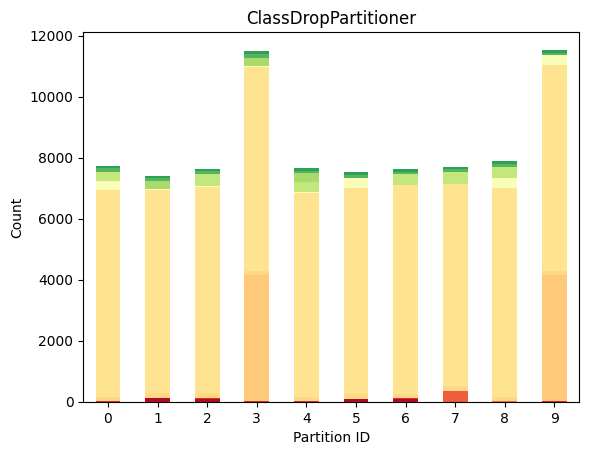

In [19]:
from utils.partition import ClassDropPartitioner

partitioner = ClassDropPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    n_drop=4,
    droppable=list(good_classes.index),
)
partitioner.dataset = dds["train"]

_ = plot_label_distributions(
    partitioner, label_name="label", title="ClassDropPartitioner"
)

In [20]:
shard = partitioner.load_partition(0)
shard_tf = dataset_to_tf(shard, batch_size=BATCH_SIZE, shuffle=True)
model = mk_model()
model.fit(shard_tf, epochs=NUM_EPOCHS, verbose=1)


Filter:   0%|          | 0/12598 [00:00<?, ? examples/s]

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7899 - loss: 0.5823
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8972 - loss: 0.3087
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9140 - loss: 0.2263
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9330 - loss: 0.1827
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9404 - loss: 0.1568


In [21]:
score_niid = eval_model(model.get_weights(), dds["test"])
score_niid

{'loss': 0.9968951940536499,
 'accuracy': np.float64(0.7159776437189496),
 'precision': np.float64(0.9690691566968194),
 'recall': np.float64(0.5175718849840255),
 'f1': np.float64(0.6747599939046071),
 'miss_rate': np.float64(0.48242811501597443)}

In [22]:
per_class_niid = eval_classes(model.get_weights(), dds["test"])
per_class_niid[per_class_niid["rate"] == 0]

,count,correct,missed,rate
apache2,737.0,0.0,737.0,0.0
back,359.0,0.0,359.0,0.0
land,7.0,0.0,7.0,0.0
loadmodule,2.0,0.0,2.0,0.0
mailbomb,293.0,0.0,293.0,0.0
named,17.0,0.0,17.0,0.0
phf,2.0,0.0,2.0,0.0
sendmail,14.0,0.0,14.0,0.0
snmpgetattack,178.0,0.0,178.0,0.0
snmpguess,331.0,0.0,331.0,0.0


## Section 3: Collaborative learning using FL

As in part I, we start with our client. This time, we will create 10 clients, each with a different partition of the data. We are closer to the cross-silo use case, where each organization is a client, with more data, more computing power, and are typically always available.

In [23]:
import flwr as fl
import tensorflow as tf


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset: tf.data.Dataset):
        keras.utils.set_random_seed(1138)  # In client thread
        self.model = mk_model()
        self.trainset = trainset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=0)
        return self.model.get_weights(), len(self.trainset), {}

In [24]:
from typing import Callable

from flwr.client import Client, ClientApp
from flwr.common import Context
from flwr_datasets.partitioner import Partitioner


def mk_client_fn(
    partitioner: Partitioner,
) -> Callable[[str], Client]:
    """Return a function which creates a new Client for a given partition."""

    def client_fn(context: Context) -> Client:
        """Create a new Client for partition i."""
        partition_id = int(context.node_config["partition-id"])
        client_dataset = partitioner.load_partition(partition_id)
        client_tf = dataset_to_tf(client_dataset, batch_size=BATCH_SIZE, shuffle=True)
        return FlowerClient(trainset=client_tf).to_client()

    return client_fn


client_fn = mk_client_fn(partitioner)
client_app = ClientApp(client_fn=client_fn)


Finally, let's try federated learning!

In [25]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg, Strategy


def mk_server_fn(
    strategy: Strategy,
    num_rounds: int = 10,
) -> Callable[[Context], ServerAppComponents]:
    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        return ServerAppComponents(
            strategy=strategy,
            config=config,
        )

    return server_fn


evaluate_fn, history = get_evaluate_fn(dds["test"])

strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Disable the federated evaluation
    min_fit_clients=NUM_CLIENTS,  # Always sample all clients
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=evaluate_fn,
    initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
)

server_app = ServerApp(server_fn=mk_server_fn(strategy, num_rounds=NUM_ROUNDS))

In [26]:
import os

# Enable GPU growth in the main process
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"

# Start simulation
fl.simulation.run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config={
        "client_resources": {
            "num_cpus": 2,
            "num_gpus": 0.1 if len(tf.config.list_physical_devices("GPU")) > 0 else 0.0,
        }
    },
)


INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.7292262315750122, {'accuracy': np.float64(0.6052608232789212), 'precision': np.float64(0.8159331834243495), 'recall': np.float64(0.3958544377776046), 'f1': np.float64(0.5330814838134215), 'miss_rate': np.float64(0.6041455622223953)}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=102829) 2025-07-19 19:45:56.691399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=102829) 2025-07-19 19:45:56.725610: E external/local_xla/xla

In [27]:
fl_weights = np.load("fl_weights.npy", allow_pickle=True)
score_fl = eval_model(fl_weights, dds["test"])
score_fl

{'loss': 1.13663911819458,
 'accuracy': np.float64(0.7621983676366217),
 'precision': np.float64(0.9786062003586984),
 'recall': np.float64(0.5952622146029767),
 'f1': np.float64(0.7402490430737924),
 'miss_rate': np.float64(0.4047377853970233)}

In [28]:
eval_classes(fl_weights, dds["test"])

,count,correct,missed,rate
apache2,737.0,108.0,629.0,0.146540
back,359.0,0.0,359.0,0.000000
buffer_overflow,20.0,3.0,17.0,0.150000
ftp_write,3.0,0.0,3.0,0.000000
guess_passwd,1231.0,22.0,1209.0,0.017872
httptunnel,133.0,51.0,82.0,0.383459
imap,1.0,0.0,1.0,0.000000
ipsweep,141.0,122.0,19.0,0.865248
land,7.0,7.0,0.0,1.000000
loadmodule,2.0,0.0,2.0,0.000000


Text(0.5, 1.0, 'NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per round')

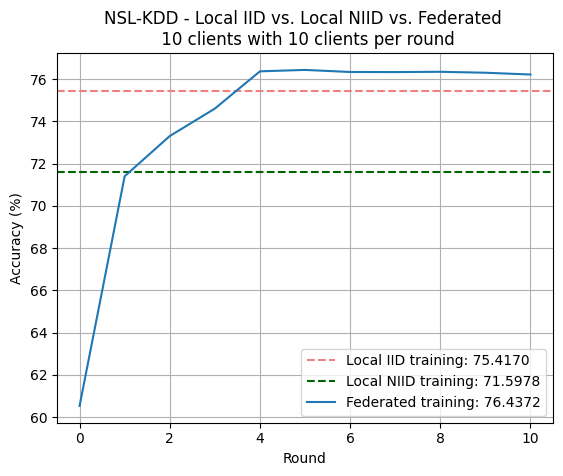

In [29]:
round = [data["round"] for data in history]
acc = [100.0 * data["accuracy"] for data in history]

iid = score_iid["accuracy"] * 100
plt.axhline(
    y=iid, label=f"Local IID training: {iid:.4f}", linestyle="--", color="lightcoral"
)
niid = score_niid["accuracy"] * 100
plt.axhline(
    y=niid, label=f"Local NIID training: {niid:.4f}", linestyle="--", color="darkgreen"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title(
    "NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per"
    " round"
)